# Import Data

In [1]:
#https://drive.google.com/file/d/1LceICrG4gH4j0pc_kq1DvKbeMt-D3Q9R/view?usp=sharing
#!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1LceICrG4gH4j0pc_kq1DvKbeMt-D3Q9R"})   # replace the id with id of file you want to access
downloaded.GetContentFile('MustangsSeason2019.csv')

In [2]:
import pandas as pd
data = pd.read_csv('MustangsSeason2019.csv')

# ECOM Metric : 
Expected Outcome to Contribution of Match

Reference: 
Bransen, L., Haaren, J. V., & Velden, M. V. (2019). 
Measuring soccer players’ contributions to chance 
creation by valuing their passes. Journal of 
Quantitative Analysis in Sports, 15(2), 97-116. doi:10.1515/jqas-2018-0020 

Create title column for identification later on group by of metric.

In [3]:
data['title'] = data['team1_name'] + ' ' + data['team1_score'].astype(str) + ' - ' + data['team2_name'] + ' ' + data['team2_score'].astype(str)

Limit data to only passes and shots

In [4]:
import pandas as pd

pd.set_option("display.max_rows", None)
data=data[['team_name','player_name','player_id','action_name','pos_x','pos_y','pos_dest_x','pos_dest_y','game','title']]

data = data[~data['pos_x'].isnull()]
data = data[~data['pos_y'].isnull()]
data = data[~data['pos_dest_x'].isnull()]
data = data[~data['pos_dest_y'].isnull()]

Create a count for whole possession sequences of the Mustangs, from pass 1 to pass n labelled the same. The next possession sequence increments. Needed to attach the outcome of the possession a shot probability label to the possession sequence.

Then labelling all shots as 'attack'

In [5]:
import numpy as np

data['count'] = np.where(data['team_name']=='SMU Mustangs',1,0)

poss = data['count'].values

count = 0
ilist = []
for i in range(0,len(poss)):
  if poss[i] == 0:
    ilist.append(poss[i])
  before = i-1
  if before == -1:
    before = 0
  if poss[before] == 0 and poss[i] != 0:
    count+=1
  if poss[i] != 0:
    ilist.append(count)

data['possession'] = ilist

del data['count']


shotall = ['Wide shot','Goal','Shot on target','Shot into the bar/post']

actions = data['action_name'].values
poss = data['possession'].values

collist = []
for i in range(0,len(actions)):
  if actions[i] in shotall and poss[i] != 0:
    collist.append('attack')
  else:
    collist.append('play')

data['on_goal'] = collist

data['on_goal'] = np.where(data['team_name']!='SMU Mustangs','opponent',data['on_goal'])

attack_poss = data[data['on_goal']=='attack']['possession'].unique()

#attack_poss

data['on_goal'] = np.where(data['possession'].isin(attack_poss),'attack',data['on_goal'])

Adding a count 1 to n to n possession sequence actions, to create a kind of primary key for individual actions. Useful later.

In [6]:
data = data[data['team_name']=='SMU Mustangs']

poss = data['possession'].values

count=1
countlist = []
for i in range(0,len(poss)):
  after = i+1
  if before < 0:
    before = 0
  try:
    if poss[i] != poss[after]:
      countlist.append(count)
      count = 1
    else:
      countlist.append(count)
      count+=1
  except IndexError:
    countlist.append(count)

data['count']=countlist

#attacking_poss[['action_name','count','possession']]

Create the label column as a primary key to give each pass a unique label.

In [7]:
data['label'] = data['possession'].astype(str) + '_' + data['count'].astype(str) + '_' + data['on_goal']

#data.head(100)

### Cluster on All Passes with Validation (SSE)

Validating the cluster number on all the passes/shots for Mustangs in 2019. The elbow plot will show a sweet spot for which we will group the pass i to pass j together for the ECOM metric.

Text(0.5, 1.0, 'Mustangs Season 2019 Passes')

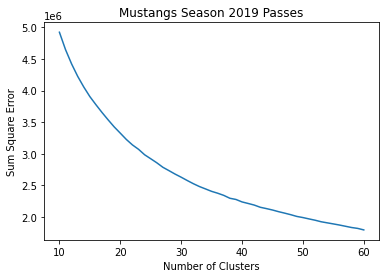

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

data_tocluster = data[['pos_x', 'pos_y', 'pos_dest_x', 'pos_dest_y']].values

nC = range(10,61)
SSE = []
for k in nC:
    k_means = KMeans(n_clusters=k,init='k-means++', random_state=1)
    k_means.fit(data_tocluster)
    SSE.append(k_means.inertia_)

plt.plot(nC, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum Square Error')
plt.title('Mustangs Season 2019 Passes')

The number of clusters chosen is 35.

In [8]:
from sklearn.cluster import KMeans

n = 35

model = KMeans(n_clusters=n)
features = data[['pos_x', 'pos_y', 'pos_dest_x', 'pos_dest_y']]
fit = model.fit(features)
clusters = model.predict(features)
data['pass_clusters'] = clusters

In [9]:
data = data.sort_values('pass_clusters')

## Probability Labels for Scoring a Goal 
attached to possession Sequences

Creating a dataframe that only has shots and creating a binary class for goal scored for the Logistic Regression.

In [10]:
import numpy as np

shotall = ['Wide shot','Shot on target','Shot into the bar/post','Goal']

shots = data[data['action_name'].isin(shotall)]
shots = shots[shots['team_name']=='SMU Mustangs']
shots['success'] = np.where(shots['action_name']=='Goal',1,0)
shots = shots[['pos_x','pos_y','success','action_name','team_name','possession','label']]

Functions borrowed from soccer analytics notebook used for logistic regression features to create probability labels.

In [11]:
def distance_to_goal(origin):
    dest = np.array([105., 34.])
    return np.sqrt(np.sum((origin - dest) ** 2))
def goal_angle(origin):
    p0 = np.array((105., 30.))  # Left Post
    p1 = np.array(origin, dtype=np.float)
    p2 = np.array((105., 48.))  # Right Post

    v0 = p0 - p1
    v1 = p2 - p1

    angle = np.abs(np.math.atan2(np.linalg.det([v0, v1]), np.dot(v0, v1)))
    
    return angle

Creating features using the functions above.

In [12]:
shots['distance_to_goal'] = shots.apply(lambda row: distance_to_goal(row[['pos_x', 'pos_y']]), axis=1)
shots['goal_angle'] = shots.apply(lambda r: goal_angle(r[['pos_x', 'pos_y']]), axis=1)

Fitting and predicting the LogReg model. No there isn't a train test split, but we need all the data as goals and shots are limited and one game simply does not have enough training data to base the rest of the season on.

In [13]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

features = shots[['distance_to_goal', 'goal_angle']]
labels = shots['success']

fit = model.fit(features, labels)

predictions = model.predict_proba(features)[:, 1]

Visualization of Predictions (sanity check)

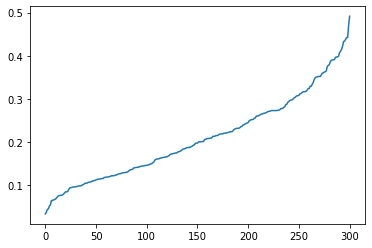

In [ ]:
import matplotlib.pyplot as plt
plt.plot(sorted(predictions))
plt.show()

Adding the probability of scoring to the shots dataframe. Remember, Shots dataframe has a column with possession sequence number that can be merged with all the passes in data. 

In [14]:
shots['scoring_probability'] = predictions
shots = shots[['possession','scoring_probability']]
#shots

Merging two datasets

In [ ]:
data.shape

(11541, 11)

Going to split the data between possession sequences that do not end in a scoring attempt and those that do. Merge the probability labelled shots with the attack possessions dataframe.

In [15]:
import pandas as pd

play = data[data['on_goal']=='play']
attack = data[data['on_goal']=='attack']
attack = pd.merge(attack,shots,on='possession')

There are multiple scoring probabilities per possession in few instances because for example a shot bounced off a goal keeper and resulted in a second shot on goal by the mustangs causes this. The solution is to average these two probabilities for possession sequences.

In [16]:
poss_prob = attack.groupby('possession')['scoring_probability'].unique()

In [17]:
poss_n = attack['possession'].unique()
poss_n.sort()
df = pd.DataFrame({'possession':poss_n,'scoring_probability':poss_prob})
#df

In [18]:
df.index.name = 'index'
attack = pd.merge(attack,df,on='possession')
scoring_probability_ys = attack['scoring_probability_y'].values
sp_list = []
for i in range(0,len(scoring_probability_ys)):
  if len(scoring_probability_ys[i]) > 1:
    sp_list.append(scoring_probability_ys[i].mean())
  else:
    sp_list.append(scoring_probability_ys[i][0])
attack['scoring_probability_3']=sp_list
#attack

The operation isn't 100% perfect, there are a few error duplicates that result for some reason.

In [19]:
attack.drop_duplicates(subset ="label",keep = False, inplace = True) 

attack = attack.sort_values(by=['possession','count'])

attack = attack.drop(labels=['scoring_probability_x','scoring_probability_y'],axis=1)

Finally concatenating the play and attack dataframes. The data is now prepared for the formulas of the ECOM metric that require sequences to labelled by their outcome else 0.

In [20]:
import pandas as pd

play['scoring_probability_3'] = 0
data = pd.concat([play,attack],axis=0)
data = data.sort_values(by=['possession','count'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
data.shape

(11398, 12)

data dataframe has clusters and scoring probabilities attached to possession sequences

### Code for Building the For Loop. Proceed to Epic For Loop Section to run. These following cells are for reference and debugging.

Clusters labelled from 0 to 34, 35 in total.
This is extra code. Creates a dataframe that creates a count for how many actions belong to each pass/shot cluster.

In [ ]:
rows_per_cluster = data.groupby('pass_clusters').count().values
rows=[]
for i in range(0,len(rows_per_cluster)):
  rows.append(rows_per_cluster[i][0])
rows
cluster = range(0,35)

clus_row_df = pd.DataFrame({'cluster':cluster,'n_row':rows})

#clus_row_df

Below is code that goes in the for loop in separate cells. Purpose is to calculate the V score per row for the Expected Contribution to Outcome of Match metric.

Select a single cluster.

In [ ]:
tmp = data[data['pass_clusters']==0]

Create a count from 1 to n actions within the cluster. This will be used to pit pass i against all pass j for the formula.

In [ ]:
tmp['clus_counter'] = range(0,len(tmp))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


The following code will explode the data n^2 to allow a comparison between pass i to every pass j

In [ ]:
tmp = (pd.merge(tmp.assign(key = 1), tmp.assign(key = 1), on = 'key').drop(columns = ['key']))



The Euclidean KNN distance function hard coded. Four arguments for pass i, Four arguments for pass j. The origins distances will be calculated, the destinations will be calculated, and those two distances will be summed and the inverse is returned according to ECOM metric formulas.

In [ ]:
def distance_passi_passj(passi_pos_x,passi_pos_y,passi_pos_dest_x,passi_pos_dest_y,
                         passj_pos_x,passj_pos_y,passj_pos_dest_x,passj_pos_dest_y,):
    passi_origin = np.array([passi_pos_x,passi_pos_y])
    passj_origin = np.array([passj_pos_x,passj_pos_y])
    origins_distance = np.sqrt(np.sum((passi_origin - passj_origin) ** 2))

    passi_dest = np.array([passi_pos_dest_x,passi_pos_dest_y])
    passj_dest = np.array([passj_pos_dest_x,passj_pos_dest_y])
    dests_distance = np.sqrt(np.sum((passi_dest - passj_dest) ** 2))

    return 1/np.sum([origins_distance,dests_distance])

Doing the calculations in several columns. Nominator should be numerator (sorry) divided by denominator. s(pi,pj) is the distance functino above.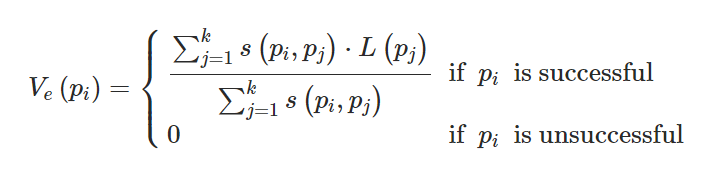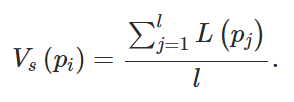

In [ ]:
import numpy as np

tmp['Ve_nominator'] = np.where(tmp['scoring_probability_3_x']>0,
                     distance_passi_passj(tmp['pos_x_x'],tmp['pos_y_x'],tmp['pos_dest_x_x'],tmp['pos_dest_y_x'],
                                          tmp['pos_x_y'],tmp['pos_y_y'],tmp['pos_dest_x_y'],tmp['pos_dest_y_y'])*tmp['scoring_probability_3_y'],
                     0)
tmp['Ve_denominator'] = np.where(tmp['scoring_probability_3_x']>0,
                     distance_passi_passj(tmp['pos_x_x'],tmp['pos_y_x'],tmp['pos_dest_x_x'],tmp['pos_dest_y_x'],
                                          tmp['pos_x_y'],tmp['pos_y_y'],tmp['pos_dest_x_y'],tmp['pos_dest_y_y']),
                     0)
tmp['Ve'] = np.where(tmp['Ve_denominator']!=0,tmp['Ve_nominator']/tmp['Ve_denominator'],0)


tmp['Vs'] = tmp['scoring_probability_3_y'] 

Collapsing the dataframe to sum the values of Ve and Vs which need to be summed/averaged.

Subtracting Ve and Vs to find V the resulting individual pass value for the ECOM metric to be summed.

In [ ]:
Ve = tmp.groupby(by='clus_counter_x')['Ve'].sum().values

Vs = tmp.groupby(by='clus_counter_x')['Vs'].mean().values

V = Ve - Vs

tmp = tmp.drop_duplicates(subset ="clus_counter_x")

tmp['V'] = V

Cleaning up the dataframe from all the columns that were doubled and not useful. The tmp dataframe rows which only have the label primary key for individual actions and the V label will be concatenated to a dataframe in the for loop for all clusters to then be merged with the original data.

In [ ]:
tmp = tmp.drop(labels=['team_name_x','action_name_x','pos_x_x','pos_y_x',
                 'pos_dest_x_x','pos_dest_y_x','possession_x','on_goal_x','count_x',
                 'pass_clusters_x','scoring_probability_3_x','clus_counter_x',
                 'team_name_y','action_name_y','pos_x_y','pos_y_y',
                 'pos_dest_x_y','pos_dest_y_y','possession_y','on_goal_y','count_y','label_y',
                 'pass_clusters_y','scoring_probability_3_y','clus_counter_y','Ve_nominator',
                 'Ve_denominator','Ve','Vs'],axis=1)
#tmp.columns

Index(['label_x', 'V'], dtype='object')

In [ ]:
tmp = tmp.rename(columns={'label_x':'label'})

Final formula for calculating ECOM metric. Though its normalized for playing time. We do not have that data and can only measure ECOM by player in total or by game. 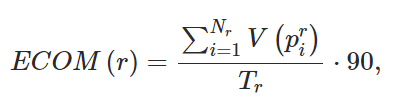

## Epic For Loop

In [21]:
def distance_passi_passj(passi_pos_x,passi_pos_y,passi_pos_dest_x,passi_pos_dest_y,
                         passj_pos_x,passj_pos_y,passj_pos_dest_x,passj_pos_dest_y,):
    passi_origin = np.array([passi_pos_x,passi_pos_y])
    passj_origin = np.array([passj_pos_x,passj_pos_y])
    origins_distance = np.sqrt(np.sum((passi_origin - passj_origin) ** 2))

    passi_dest = np.array([passi_pos_dest_x,passi_pos_dest_y])
    passj_dest = np.array([passj_pos_dest_x,passj_pos_dest_y])
    dests_distance = np.sqrt(np.sum((passi_dest - passj_dest) ** 2))

    return 1/np.sum([origins_distance,dests_distance])

In [22]:
import numpy as np


df = pd.DataFrame(data={'label':[0],'V':[0]})


for i in range(0,35):

  tmp = data[data['pass_clusters']==i]

  tmp['clus_counter'] = range(0,len(tmp))

  tmp = (pd.merge(tmp.assign(key = 1), tmp.assign(key = 1), on = 'key').drop(columns = ['key']))


  tmp['Ve_nominator'] = np.where(tmp['scoring_probability_3_x']>0,
                      distance_passi_passj(tmp['pos_x_x'],tmp['pos_y_x'],tmp['pos_dest_x_x'],tmp['pos_dest_y_x'],
                                            tmp['pos_x_y'],tmp['pos_y_y'],tmp['pos_dest_x_y'],tmp['pos_dest_y_y'])*tmp['scoring_probability_3_y'],
                      0)
  tmp['Ve_denominator'] = np.where(tmp['scoring_probability_3_x']>0,
                      distance_passi_passj(tmp['pos_x_x'],tmp['pos_y_x'],tmp['pos_dest_x_x'],tmp['pos_dest_y_x'],
                                            tmp['pos_x_y'],tmp['pos_y_y'],tmp['pos_dest_x_y'],tmp['pos_dest_y_y']),
                      0)
  tmp['Ve'] = np.where(tmp['Ve_denominator']!=0,tmp['Ve_nominator']/tmp['Ve_denominator'],0)
  tmp['Vs'] = tmp['scoring_probability_3_y'] 

  Ve = tmp.groupby(by='clus_counter_x')['Ve'].sum().values

  Vs = tmp.groupby(by='clus_counter_x')['Vs'].mean().values

  V = Ve - Vs

  tmp = tmp.drop_duplicates(subset ="clus_counter_x")

  tmp['V'] = V

  tmp = tmp.drop(labels=['team_name_x','action_name_x','pos_x_x','pos_y_x',
                  'pos_dest_x_x','pos_dest_y_x','possession_x','on_goal_x','count_x',
                  'pass_clusters_x','scoring_probability_3_x','clus_counter_x',
                  'team_name_y','action_name_y','pos_x_y','pos_y_y',
                  'pos_dest_x_y','pos_dest_y_y','possession_y','on_goal_y','count_y','label_y',
                  'pass_clusters_y','scoring_probability_3_y','clus_counter_y','Ve_nominator',
                  'Ve_denominator','Ve','Vs','player_name_x','player_name_y','player_id_x','player_id_y',
                  'game_x','game_y'],axis=1)

  tmp = tmp.rename(columns={'label_x':'label'})

  df = pd.concat([df,tmp],axis=0)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Merging the df dataframe that has the unique labels for pass/shots and the original data dataframe.

In [23]:
#df.drop(,axis=0)

data = pd.merge(data,df.iloc[1:],on='label')

# Results ECOM Metric
by Player for 2019 Season

In [25]:
data.groupby(by=['player_name'])['V'].sum()

player_name
Brandon Terwege       2779.265326
Cole Rainwater          -0.180195
DJ Williams            947.603419
Eddie Munjoma         4992.001544
Gabriel Costa         5195.275642
Garrett McLaughlin    5321.915139
Grant Makela           147.309621
Henrik Bredeli        2409.583968
Henry Smith-Hastie     749.649758
Jacob Cohen             18.995644
Jon-Talen Maples      1112.337581
Joshua Berney          104.517632
Knut Ahlander         5726.624188
Lane Warrington       1350.094884
Luke Thompson          156.311793
Nick Taylor           1066.213089
Nicky Hernandez       3408.793545
Noah Hilt             1984.610669
Philip Ponder         1619.700570
Shane Lanson            51.902949
Thomas Haney           919.918774
Tobin Shanks           148.682174
Wyatt Priest           514.760148
Name: V, dtype: float64

# Results Again 
by game

In [24]:
data.groupby(by=['player_name','title'])['V'].sum()

player_name         title                                           
Brandon Terwege     Cincinnati Bearcats 1 - SMU Mustangs 7              170.922707
                    Coastal Carolina Chanticleers 0 - SMU Mustangs 1    222.029121
                    Denver Pioneers 1 - SMU Mustangs 2                  142.386535
                    Duke Blue Devils 0 - SMU Mustangs 2                  -1.234165
                    SMU Mustangs 1 - Connecticut Huskies 0              228.032666
                    SMU Mustangs 1 - UC Riverside Highlanders 0          46.300573
                    SMU Mustangs 2 - Saint Louis Billikens 0            249.066461
                    SMU Mustangs 2 - South Florida Bulls 1              108.970113
                    SMU Mustangs 2 - UCF Knights 1                      103.958097
                    SMU Mustangs 3 - Central Arkansas Bears 0            92.394078
                    SMU Mustangs 3 - Memphis Tigers 4                   194.425271
                  